# ICA Analysis Comparison on Motor Sensory Data

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from mne.preprocessing import ICA
import mne
from mne_icalabel import label_components
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


## Extract Files for 4 Subjects

In [3]:
base_dir = 'physionet.org/files/eegmmidb/1.0.0'
all_files = []

for subj in os.listdir(base_dir):
    subj_dir = os.path.join(base_dir, subj)
    if os.path.isdir(subj_dir):
        for run in os.listdir(subj_dir):
            if run.endswith('.edf'):
                all_files.append(os.path.join(subj_dir, run))

## Map the 10-20 Montage system 

In [4]:
def clean_ch_name(ch):
    ch = ch.strip('.')  # Remove all dots
    # Correct some common mis-capitalizations (e.g., 'Fc5' to 'FC5')
    # 'Fc' and 'Cp' are sometimes written as 'FC' and 'CP' in high-density
    if ch.startswith('Fc'):
        ch = 'FC' + ch[2:]
    elif ch.startswith('Cp'):
        ch = 'CP' + ch[2:]
    if ch == 'Poz':  # Some montages use 'POz'
        ch = 'POz'
    if ch == 'Afz':  # Some montages use 'AFz'
        ch = 'AFz'
    return ch


## Apply PCA Whitening and ICA to remove Artifacts

In [ ]:
X_raw_all, X_clean_all, y_all = [], [], []

for file in all_files:
    print(f"Processing {file}...")
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
    mapping = {old: clean_ch_name(old) for old in raw.ch_names}
    raw.rename_channels(mapping)
    raw.set_montage('standard_1020', match_case=False)
    raw.set_eeg_reference('average')
    raw.filter(1., 30., fir_design='firwin', verbose=False) #test different widths

    # Extract events and epochs
    events, event_id = mne.events_from_annotations(raw)
    # Only use events with valid labels (not baseline)
    valid_events = [e for e in events if e[2] in event_id.values()]
    if not valid_events:
        print(f"No valid events in {file}, skipping...")
        continue
    epochs = mne.Epochs(raw, valid_events, event_id=event_id, tmin=-0.5, tmax=4, baseline=(-0.5, 0), preload=True, verbose=False)
    # print("Highpass filter cutoff (Hz):", epochs.info['highpass'])
    # print("Lowpass filter cutoff (Hz):", epochs.info['lowpass'])
    
    X = epochs.get_data()
    if X.shape[0] == 0:
        print(f"No valid epochs in {file}, skipping...")
        continue  # Skip to the next file

    y = epochs.events[:, -1]
    print(f"File: {file}, X shape: {X.shape}, y shape: {y.shape}")
    assert X.shape[0] == len(y), f"Mismatch in file {file}: X.shape[0]={X.shape[0]}, len(y)={len(y)}"
    
    # --- ICA with PCA whitening ---

    ica = mne.preprocessing.ICA(
    method='infomax',
    fit_params=dict(extended=True),
    n_components=0.99,
    random_state=42
)
    ica.fit(epochs)

    # Label components using ICLabel
    ic_labels = label_components(epochs, ica, method="iclabel")
    print(ic_labels)

    exclude_idx = []
    for idx, label in enumerate(ic_labels["labels"]):
        if label in ["eye", "muscle", "heart", "line noise", "channel noise"]:
            exclude_idx.append(idx)
    ica.exclude = exclude_idx

    # USe built in artifact removal since it's too much manual labor without clinical domain knowledge
    ica.apply(epochs)
    X_clean = epochs.get_data()

    X_raw_all.append(X)
    X_clean_all.append(X_clean)
    y_all.append(y)

# Combine all data
X_raw = np.concatenate(X_raw_all)
X_clean = np.concatenate(X_clean_all)
y = np.concatenate(y_all)
print("After concatenation:")
print("X_raw shape:", X_raw.shape)
print("y shape:", y.shape)


## Feature Extraction

In [6]:
# --- Feature extraction ---
from scipy.signal import stft
from mne.decoding import CSP
from scipy.stats import entropy
from scipy.signal import welch
from scipy.stats import skew, kurtosis


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, random_state=42)
X_train_clean, X_test_clean, _, _ = train_test_split(X_clean, y, stratify=y, random_state=42)


def stft_features(X, fs=160, nperseg=64):
    """Compute STFT-based features for each epoch and channel."""
    f, t, Zxx = stft(X, fs=fs, nperseg=nperseg, axis=2)
    # Example: mean power in each frequency band for each channel and epoch
    mean_power = np.mean(np.abs(Zxx), axis=3)  # Mean over time
    return mean_power.reshape(X.shape[0], -1)  # Flatten for ML

X_stft_raw = stft_features(X_raw)
X_stft_clean = stft_features(X_clean)

def extract_features(X):
    """Extract time and frequency domain features from EEG epochs."""
    psd = np.abs(np.fft.rfft(X, axis=2)) ** 2
    psd_mean = psd.mean(axis=2)
    psd_std = psd.std(axis=2)
    time_mean = X.mean(axis=2)
    time_std = X.std(axis=2)
    return np.concatenate([time_mean, time_std, psd_mean, psd_std], axis=1)

def hjorth_parameters(x):
    """Compute Hjorth activity, mobility, complexity for a 1D signal."""
    x = np.asarray(x)
    first_deriv = np.diff(x)
    second_deriv = np.diff(first_deriv)
    activity = np.var(x)
    mobility = np.sqrt(np.var(first_deriv) / activity)
    complexity = np.sqrt(np.var(second_deriv) / np.var(first_deriv)) / mobility
    return activity, mobility, complexity

def extract_hjorth(X):
    """Extract Hjorth parameters for each epoch and channel."""
    n_epochs, n_channels, n_times = X.shape
    hjorth = np.zeros((n_epochs, n_channels, 3))
    for i in range(n_epochs):
        for j in range(n_channels):
            hjorth[i, j] = hjorth_parameters(X[i, j])
    return hjorth.reshape(n_epochs, -1)  # Flatten for ML

def spectral_entropy(x, fs=160):
    """Compute spectral entropy for a 1D signal."""
    f, pxx = welch(x, fs=fs)
    pxx = pxx / np.sum(pxx)
    return entropy(pxx)

def extract_entropy(X, fs=160):
    """Extract Shannon and spectral entropy for each epoch and channel."""
    n_epochs, n_channels, n_times = X.shape
    ent = np.zeros((n_epochs, n_channels, 2))
    for i in range(n_epochs):
        for j in range(n_channels):
            x = X[i, j]
            ent[i, j, 0] = entropy(np.abs(x))  # Shannon entropy (simplified)
            ent[i, j, 1] = spectral_entropy(x, fs=fs)
    return ent.reshape(n_epochs, -1)

def extract_skew_kurtosis(X):
    """Extract skewness and kurtosis for each epoch and channel."""
    n_epochs, n_channels, n_times = X.shape
    sk = np.zeros((n_epochs, n_channels, 2))
    for i in range(n_epochs):
        for j in range(n_channels):
            sk[i, j, 0] = skew(X[i, j])
            sk[i, j, 1] = kurtosis(X[i, j])
    return sk.reshape(n_epochs, -1)

def extract_all_features(X, fs=160):
    """Combine all feature extractors into one."""
    sum = extract_features(X)
    stft = stft_features(X)
    hjorth = extract_hjorth(X)
    ent = extract_entropy(X, fs=fs)
    sk = extract_skew_kurtosis(X)
    return np.concatenate([sum, stft, hjorth, ent, sk], axis=1)


# Split data before feature extraction
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, random_state=42)
X_train_clean, X_test_clean, _, _ = train_test_split(X_clean, y, stratify=y, random_state=42)

# Extract all features for train and test sets (raw and clean)
X_train_raw_feat = extract_all_features(X_train_raw)
X_test_raw_feat = extract_all_features(X_test_raw)
X_train_clean_feat = extract_all_features(X_train_clean)
X_test_clean_feat = extract_all_features(X_test_clean)

# Fit CSP and extract CSP features for train and test sets
csp = CSP(n_components=4, reg=None, log=True)

# Raw data
X_csp_train_raw = csp.fit_transform(X_train_raw, y_train)
X_csp_test_raw = csp.transform(X_test_raw)

# Cleaned data
X_csp_train_clean = csp.fit_transform(X_train_clean, y_train)
X_csp_test_clean = csp.transform(X_test_clean)

# Combine all features for train and test sets
X_train_raw_combined = np.concatenate([X_train_raw_feat, X_csp_train_raw], axis=1)
X_test_raw_combined = np.concatenate([X_test_raw_feat, X_csp_test_raw], axis=1)
X_train_clean_combined = np.concatenate([X_train_clean_feat, X_csp_train_clean], axis=1)
X_test_clean_combined = np.concatenate([X_test_clean_feat, X_csp_test_clean], axis=1)

# Scale features
scaler = StandardScaler()

# Raw data
X_train_raw_scaled = scaler.fit_transform(X_train_raw_combined)
X_test_raw_scaled = scaler.transform(X_test_raw_combined)

# Cleaned data
X_train_clean_scaled = scaler.fit_transform(X_train_clean_combined)
X_test_clean_scaled = scaler.transform(X_test_clean_combined)

Computing rank from data with rank=None
    Using tolerance 0.0028 (2.2e-16 eps * 64 dim * 2e+11  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0028 (2.2e-16 eps * 64 dim * 2e+11  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.


## Random Forest

In [39]:
# --- Train/test split ---
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# --- Classification ---
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_random_raw = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
rf_random_raw.fit(X_train_raw_scaled, y_train)
print("Best parameters:", rf_random_raw.best_params_)
print("Best cross-validation accuracy:", rf_random_raw.best_score_)
best_rf_raw = rf_random_raw.best_estimator_

y_pred_raw = best_rf_raw.predict(X_test_raw_scaled)

rf_random_clean = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

rf_random_clean.fit(X_train_clean_scaled, y_train)
print("Best parameters:", rf_random_clean.best_params_)
print("Best cross-validation accuracy:", rf_random_clean.best_score_)
best_rf_clean = rf_random_clean.best_estimator_
y_pred_clean = best_rf_clean.predict(X_test_clean_scaled)


Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Best cross-validation accuracy: 0.6197966507177034
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
Best cross-validation accuracy: 0.626463010673537


## MLP

In [40]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization)
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 400],
    'early_stopping': [True, False],
    'batch_size': [32, 64]
}

mlp = MLPClassifier(random_state=42)

mlp_random = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_grid_mlp,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)
# For raw data
mlp_random.fit(X_train_raw_scaled, y_train)
print("Best parameters (raw):", mlp_random.best_params_)
print("Best cross-validation accuracy (raw):", mlp_random.best_score_)
best_mlp_raw = mlp_random.best_estimator_
y_pred_raw_mlp = best_mlp_raw.predict(X_test_raw_scaled)

# For cleaned data
mlp_random.fit(X_train_clean_scaled, y_train)
print("Best parameters (clean):", mlp_random.best_estimator_.get_params())
print("Best cross-validation accuracy (clean):", mlp_random.best_score_)
best_mlp_clean = mlp_random.best_estimator_
y_pred_clean_mlp = best_mlp_clean.predict(X_test_clean_scaled)

Best parameters (raw): {'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'early_stopping': False, 'batch_size': 64, 'alpha': 0.001, 'activation': 'relu'}
Best cross-validation accuracy (raw): 0.6427355539197644
Best parameters (clean): {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Best cross-validation accuracy (clean): 0.6561832903938167


## EEGNet 

In [14]:
# Advanced Neural Networks for EEG Motor Imagery Classification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# EEGNet - Specifically designed for EEG classification
# https://arxiv.org/abs/1611.08024
class EEGNet(nn.Module):
    def __init__(self, n_classes, n_channels=64, n_samples=721, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        
        # Layer 1: Temporal convolution
        self.temporal_conv = nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False)
        self.temporal_bn = nn.BatchNorm2d(16)
        
        # Layer 2: Spatial convolution (depthwise)
        self.spatial_conv = nn.Conv2d(16, 32, (n_channels, 1), groups=16, bias=False)
        self.spatial_bn = nn.BatchNorm2d(32)
        self.spatial_pool = nn.AvgPool2d((1, 4))
        self.spatial_dropout = nn.Dropout(dropout_rate)
        
        # Layer 3: Separable convolution
        self.separable_conv1 = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32, bias=False)
        self.separable_conv2 = nn.Conv2d(32, 16, (1, 1), bias=False)
        self.separable_bn = nn.BatchNorm2d(16)
        self.separable_pool = nn.AvgPool2d((1, 8))
        self.separable_dropout = nn.Dropout(dropout_rate)
        
        # Calculate the size for the fully connected layer
        self._to_linear = None
        self.convs = nn.Sequential(
            self.temporal_conv, self.temporal_bn,
            self.spatial_conv, self.spatial_bn, self.spatial_pool, self.spatial_dropout,
            self.separable_conv1, self.separable_conv2, self.separable_bn, 
            self.separable_pool, self.separable_dropout
        )
        
        # Dummy forward pass to calculate flatten size
        x = torch.randn(1, 1, n_channels, n_samples)
        self._get_conv_output_size(x)
        
        # Classifier
        self.classifier = nn.Linear(self._to_linear, n_classes)
        
    def _get_conv_output_size(self, x):
        x = F.elu(self.temporal_conv(x))
        x = self.temporal_bn(x)
        x = F.elu(self.spatial_conv(x))
        x = self.spatial_bn(x)
        x = self.spatial_pool(x)
        x = self.spatial_dropout(x)
        x = F.elu(self.separable_conv1(x))
        x = F.elu(self.separable_conv2(x))
        x = self.separable_bn(x)
        x = self.separable_pool(x)
        x = self.separable_dropout(x)
        self._to_linear = x.numel()
        
    def forward(self, x):
        # Add channel dimension if needed
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
            
        x = F.elu(self.temporal_conv(x))
        x = self.temporal_bn(x)
        x = F.elu(self.spatial_conv(x))
        x = self.spatial_bn(x)
        x = self.spatial_pool(x)
        x = self.spatial_dropout(x)
        x = F.elu(self.separable_conv1(x))
        x = F.elu(self.separable_conv2(x))
        x = self.separable_bn(x)
        x = self.separable_pool(x)
        x = self.separable_dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



# Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss / len(val_loader))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses, train_accs, val_accs

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

# Function to prepare data for PyTorch
def prepare_data_for_pytorch(X_train, X_test, y_train, y_test, batch_size=32):
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Function to compare all models
def compare_models(X_train_raw, X_test_raw, X_train_clean, X_test_clean, y_train, y_test):
    """Compare different neural network architectures on raw vs cleaned data"""
    
    # Prepare data
    n_classes = len(np.unique(y_train))
    n_channels = X_train_raw.shape[1]
    n_samples = X_train_raw.shape[2]
    
    # Map labels to start from 0
    unique_labels = np.unique(np.concatenate([y_train, y_test]))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    y_train_mapped = np.array([label_map[label] for label in y_train])
    y_test_mapped = np.array([label_map[label] for label in y_test])
    
    results = {}
    
    for data_type, (X_train, X_test) in [('Raw', (X_train_raw, X_test_raw)), 
                                         ('ICA_Cleaned', (X_train_clean, X_test_clean))]:
        print(f"\n--- Testing on {data_type} Data ---")
        
        # Split validation set from training
        val_split = int(0.2 * len(X_train))
        X_val, X_train_sub = X_train[:val_split], X_train[val_split:]
        y_val, y_train_sub = y_train_mapped[:val_split], y_train_mapped[val_split:]
        
        # Prepare data loaders
        train_loader, _ = prepare_data_for_pytorch(X_train_sub, X_test, y_train_sub, y_test_mapped)
        val_loader, _ = prepare_data_for_pytorch(X_val, X_test, y_val, y_test_mapped)
        _, test_loader = prepare_data_for_pytorch(X_train, X_test, y_train_mapped, y_test_mapped)
        
        model = EEGNet(n_classes, n_channels, n_samples).to(device)
            
        # Train model
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=50, lr=0.001
        )
            
        # Evaluate on test set
        test_acc, test_preds, test_labels = evaluate_model(model, test_loader)
        
        # Store results
        results[f'EEGNet_{data_type}'] = {
            'accuracy': test_acc,
            'predictions': test_preds,
            'labels': test_labels,
            'train_history': {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs
            }
        }
        
        print(f"EEGNet on {data_type} data - Test Accuracy: {test_acc:.4f}")

    return results


nn_results = compare_models(X_train_raw, X_test_raw, 
                           X_train_clean, X_test_clean, 
                            y_train, y_test)



Using device: cpu

--- Testing on Raw Data ---
Epoch 0: Train Acc: 0.3864, Val Acc: 0.5000
Epoch 10: Train Acc: 0.7249, Val Acc: 0.6202
Epoch 20: Train Acc: 0.7656, Val Acc: 0.6442
Epoch 30: Train Acc: 0.8002, Val Acc: 0.6442
Epoch 40: Train Acc: 0.8146, Val Acc: 0.6490
EEGNet on Raw data - Test Accuracy: 0.7069

--- Testing on ICA_Cleaned Data ---
Epoch 0: Train Acc: 0.3971, Val Acc: 0.5000
Epoch 10: Train Acc: 0.7237, Val Acc: 0.6779
Epoch 20: Train Acc: 0.7907, Val Acc: 0.6635
Epoch 30: Train Acc: 0.8170, Val Acc: 0.6683
Early stopping at epoch 31
EEGNet on ICA_Cleaned data - Test Accuracy: 0.6839


## RF Confusion Matrix


Accuracy Improvement from ICA: -0.014


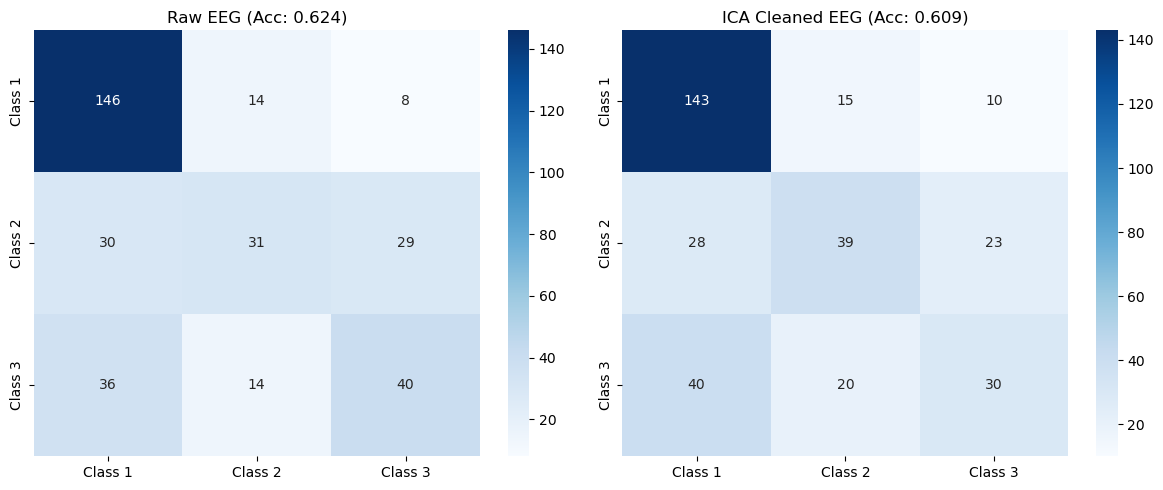

In [41]:
# --- Results RF ---
acc_raw = np.mean(y_pred_raw == y_test)
acc_clean = np.mean(y_pred_clean == y_test)
print(f"\nAccuracy Improvement from ICA: {acc_clean - acc_raw:+.3f}")

cm_raw = confusion_matrix(y_test, y_pred_raw)
cm_clean = confusion_matrix(y_test, y_pred_clean)

class_names = [f"Class {i}" for i in np.unique(y_test)]  # Adjust if you know the actual labels

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Raw EEG (Acc: {acc_raw:.3f})')
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'ICA Cleaned EEG (Acc: {acc_clean:.3f})')
plt.tight_layout()
plt.show()

## MLP Confusion Matrix


Accuracy Improvement from ICA: +0.006


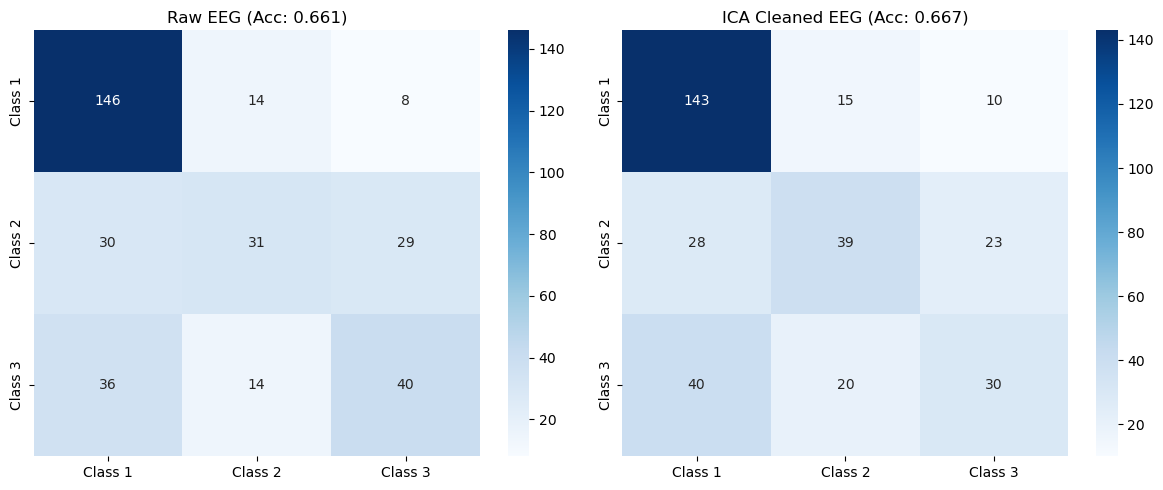

In [42]:
# --- Results MLP  ---
acc_raw = np.mean(y_pred_raw_mlp == y_test)
acc_clean = np.mean(y_pred_clean_mlp == y_test)
print(f"\nAccuracy Improvement from ICA: {acc_clean - acc_raw:+.3f}")

cm_raw = confusion_matrix(y_test, y_pred_raw)
cm_clean = confusion_matrix(y_test, y_pred_clean)

class_names = [f"Class {i}" for i in np.unique(y_test)]  # Adjust if you know the actual labels

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Raw EEG (Acc: {acc_raw:.3f})')
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'ICA Cleaned EEG (Acc: {acc_clean:.3f})')
plt.tight_layout()
plt.show()


## EEGNet Confusion Matrix


Accuracy Improvement from ICA: -0.023


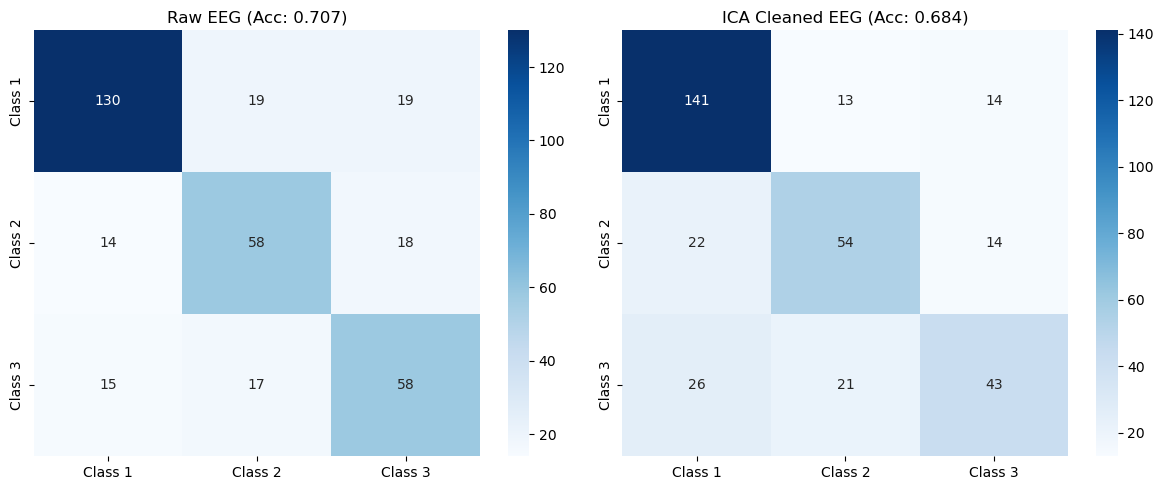

In [38]:
# --- Results EEGNet ---

y_pred_raw_nn = np.array(nn_results['EEGNet_Raw']['predictions']) + 1
y_pred_clean_nn = np.array(nn_results['EEGNet_ICA_Cleaned']['predictions']) + 1

acc_raw = np.mean(y_pred_raw_nn == y_test)
acc_clean = np.mean(y_pred_clean_nn  == y_test)
print(f"\nAccuracy Improvement from ICA: {acc_clean - acc_raw:+.3f}")

cm_raw = confusion_matrix(y_test, y_pred_raw_nn)
cm_clean = confusion_matrix(y_test, y_pred_clean_nn)

class_names = [f"Class {i}" for i in np.unique(y_test)]  # Adjust if you know the actual labels

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Raw EEG (Acc: {acc_raw:.3f})')
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'ICA Cleaned EEG (Acc: {acc_clean:.3f})')
plt.tight_layout()
plt.show()